Now we have seen how to build a model, let's use these concepts to build a predictive model on our data.

Specifically, we are going to try to predict the return of SOL in the next hour with a simple model that uses hourly volatility and close returns

In [60]:
data_location = 'sqlite:///../../data/data.db'

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [62]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [63]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [64]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [65]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [66]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Data formatting

First, let's format the data.  right now the data set is long, i.e. each row is unique on ts/token, however we want to make each row unique on ts only.  We are converting a long table into a fat table of features

In [67]:
tokens = ohlc.token.unique()

In [69]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [70]:
X.shape

(1057, 22)

In [71]:
X.tail()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,0.158369,0.005961,0.002463,0.0001,0.216740,0.002798,0.225286,0.014437,...,0.239258,0.008227,0.254118,-0.000471,0.255464,0.003049,0.207758,0.009387,0.284268,0.006813
2021-12-14 21:00:00,0.142237,0.019797,0.170096,0.016737,0.002652,0.0000,0.218492,0.025892,0.224116,0.012141,...,0.241603,0.019207,0.254350,0.019303,0.263456,0.021277,0.222014,0.022490,0.281497,0.017473
2021-12-14 22:00:00,0.151148,0.010414,0.172081,0.004623,0.002684,0.0000,0.246122,0.015624,0.232362,0.009295,...,0.268875,0.026851,0.253472,0.012933,0.270895,0.023810,0.220598,0.006242,0.275083,0.009868
2021-12-14 23:00:00,0.149424,-0.000302,0.170257,-0.003195,0.002823,0.0001,0.238235,-0.010027,0.231115,-0.000157,...,0.301778,0.032506,0.245708,-0.009576,0.268758,-0.011628,0.219474,-0.003013,0.271229,-0.000864
2021-12-15 00:00:00,0.143079,-0.001448,0.159883,-0.000641,0.002816,0.0000,0.228867,0.002517,0.220068,-0.007715,...,0.296444,0.005576,0.234522,-0.003223,0.242546,-0.002941,0.213360,0.001659,0.246067,-0.001027


let's separate out our X and y variables now.  We want to make sure that we are shifting the y variable by 1 step, since we want to predict 1 step into the future

In [77]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [78]:
X.shape

(1056, 22)

In [79]:
y.shape

(1056,)

Let's analyze our data a little bit

In [80]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [81]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

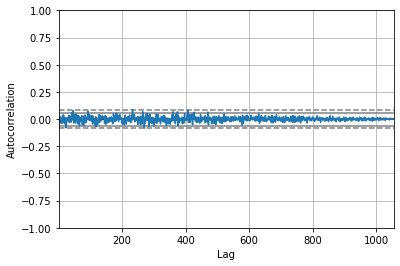

In [82]:
autocorrelation_plot(y[1:])

we can see that the hourly returns for aave doesn't have any strong autocorrelation

In [84]:
X.head()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2021-11-01 01:00:00,0.0,0.004357,0.0,0.006874,0.0,0.0000,0.0,0.027359,0.0,0.003203,...,0.0,-0.006346,0.0,0.008193,0.0,0.000725,0.0,0.008043,0.0,-0.002281
2021-11-01 02:00:00,0.0,-0.004508,0.0,-0.005322,0.0,-0.0002,0.0,-0.009879,0.0,-0.008667,...,0.0,-0.006231,0.0,-0.025419,0.0,-0.031791,0.0,-0.009171,0.0,-0.006020
2021-11-01 03:00:00,0.0,-0.012132,0.0,-0.013126,0.0,0.0001,0.0,-0.021692,0.0,-0.007618,...,0.0,-0.005329,0.0,-0.013943,0.0,-0.010431,0.0,-0.013301,0.0,-0.022273
2021-11-01 04:00:00,0.0,-0.010186,0.0,-0.010679,0.0,0.0000,0.0,-0.003039,0.0,-0.006903,...,0.0,-0.008667,0.0,-0.020046,0.0,0.004514,0.0,-0.016452,0.0,-0.024002


In [83]:
pd.isnull(X).sum()

vol_BTC     0
ret_BTC     1
vol_ETH     0
ret_ETH     1
vol_USDT    0
ret_USDT    1
vol_SOL     0
ret_SOL     1
vol_ADA     0
ret_ADA     1
vol_DOT     0
ret_DOT     1
vol_AVAX    0
ret_AVAX    1
vol_ATOM    0
ret_ATOM    1
vol_CRV     0
ret_CRV     1
vol_AAVE    0
ret_AAVE    1
vol_COMP    0
ret_COMP    1
dtype: int64

we see that we have some nulls, so our transformers should deal with this.  The reason we have these is because the first value in our series doesn't have a return, so we should impute these to be zero

In [85]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573316,
 'ret_BTC': -0.013848623804147297,
 'vol_ETH': 0.02357151289469286,
 'ret_ETH': 0.03064921265933825,
 'vol_USDT': 0.006850180191310921,
 'ret_USDT': -0.044400854990527476,
 'vol_SOL': 0.03485259726638474,
 'ret_SOL': -0.02985506419340651,
 'vol_ADA': 0.03888023343700741,
 'ret_ADA': 0.0002492833396142092,
 'vol_DOT': 0.059040768451671846,
 'ret_DOT': 0.008193946995455023,
 'vol_AVAX': 0.04140851156078151,
 'ret_AVAX': 0.01691945028976708,
 'vol_ATOM': -0.0022346077856851623,
 'ret_ATOM': 0.05546161881659775,
 'vol_CRV': 0.019828890149893363,
 'ret_CRV': -0.005844145396121401,
 'vol_AAVE': 0.03605077807280678,
 'ret_AAVE': 0.01989568673206619,
 'vol_COMP': 0.05984258530861503,
 'ret_COMP': 0.020113141490153065}

finally, we can take a quick look at the correlation between y and our X variables.  We see here that the correlations are pretty weak on a column by column basis

Next, let's set up a set of transformers so that we can augment our data before it hits the model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [88]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

In [89]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01382478738592176

In [90]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01342180034409326

In [91]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.012880711478314369

In [95]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.011607067332651076

In [93]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008887617620685049

In [94]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008915840604257463

In [96]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.00859065527374931

In [97]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.008583256091590224

In [101]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.))
])

evaluate_model(pipeline, X, y)

-0.008582626565834287

The above looks pretty good, however let's optimize the alpha parameter on the Ridge

In [103]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [104]:
search.best_params_

{'model__alpha': 0.1, 'pca__n_components': 20}

In [106]:
best_model = search.best_estimator_

In [107]:
evaluate_model(best_model, X, y)

-0.008575141851714435

Let's check the learning curve of our best model

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

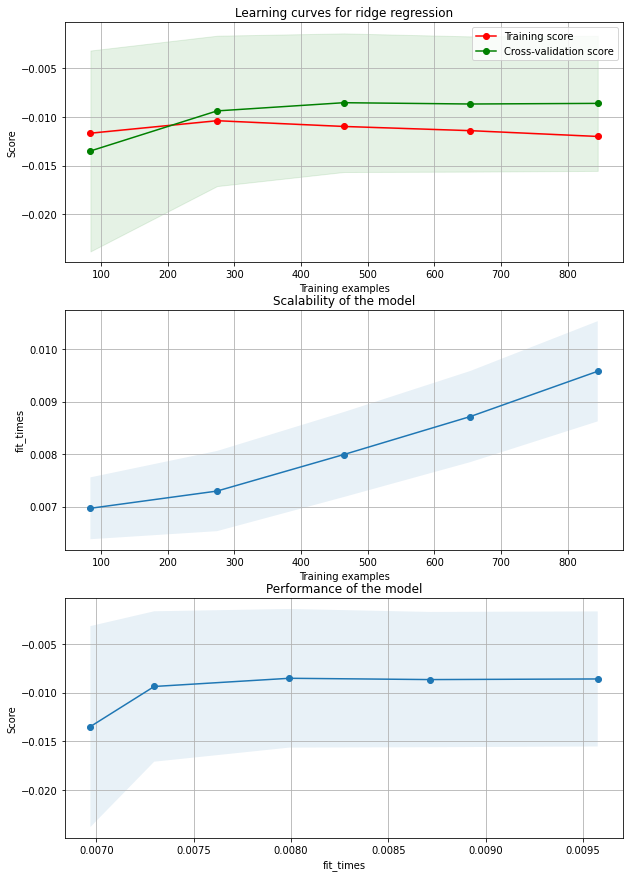

In [108]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


Now that we have completed the model, we will need to save it down so that we can load it up in our model.  To do this, we will use pickle

In [110]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

We can verify that this is the same model that we saved:

In [111]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [112]:
loaded_model == best_model

False

In [113]:
loaded_model.predict(X.iloc[[-1]])

array([0.00040572])

In [114]:
best_model.predict(X.iloc[[-1]])

array([0.00040572])

In [115]:
best_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('pca', PCA(n_components=20)),
                ('model', Ridge(alpha=0.1))])

In [116]:
loaded_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('pca', PCA(n_components=20)),
                ('model', Ridge(alpha=0.1))])

In [117]:
evaluate_model(best_model, X, y)

-0.008575141851714435

In [118]:
evaluate_model(loaded_model, X, y)

-0.008575141851714435

we can now take this model and build a server around it, so that other systems can also now make predictions on the hourly returns of SOL!